# 1. **Cross-Correlation**
Each output unit is a linear function of a localized subset of input units.
Cross-correlation is an operation used to measure the **similarity** between a filter/kernel and a region of an image (or feature map). It's defined as:

$
(f \star g)[i, j] = \sum_m \sum_n f[i + m, j + n] \cdot g[m, n]
$

- You slide the kernel `g` over the input `f`.
- You **do not flip** the kernel.
- Multiply corresponding elements and sum them.

This is the **actual operation** used in deep learning frameworks like PyTorch and TensorFlow when we say "convolution".

---

# 2. **Convolution**

Mathematically, convolution involves **flipping the kernel** both horizontally and vertically before applying it:

$
(f * g)[i, j] = \sum_m \sum_n f[i + m, j + n] \cdot g[-m, -n]
$

- Used in signal processing.
- Has properties like **commutativity** and **associativity** that are useful in theory.

---


**Why DL Libraries Use Cross-Correlation?**

Because in learning, the **filter is learned**, and flipping it doesn’t add value—so it’s simpler to define the operation as cross-correlation.

![](images/cnn-explainer.gif)
[credit](https://poloclub.github.io/cnn-explainer/)

In [46]:
import torch
import torch.nn.functional as F

# Input tensor (1 image, 1 channel, 5x5)
input = torch.tensor([[[[1., 2., 3., 0., 1.],
                        [0., 1., 2., 3., 1.],
                        [1., 0., 1., 2., 2.],
                        [2., 1., 0., 1., 3.],
                        [1., 2., 3., 0., 1.]]]])
print(input.shape)
# Kernel (1 filter, 1 channel, 3x3)
kernel = torch.tensor([[[[0., 1., 0.],
                         [1., -4., 1.],
                         [0., 1., 0.]]]])

# Apply cross-correlation (no flip), In CNNs, we don't usually flip the kernel because weights are learned.
cross_corr = F.conv2d(input, kernel)
print("Cross-correlation result:\n", cross_corr)

# Flip kernel to do convolution
flipped_kernel = torch.flip(kernel, [2, 3])  # Flip height and width
conv_result = F.conv2d(input, flipped_kernel)
print("\nConvolution result:\n", conv_result)

torch.Size([1, 1, 5, 5])
Cross-correlation result:
 tensor([[[[ 0.,  0., -7.],
          [ 4.,  0., -1.],
          [ 0.,  6.,  1.]]]])

Convolution result:
 tensor([[[[ 0.,  0., -7.],
          [ 4.,  0., -1.],
          [ 0.,  6.,  1.]]]])


---
# **3. Most Common Types of Convolution in Deep Learning**

###  **3.1. Standard (2D) Convolution**

####  What it does:
- Applies a **learnable kernel** over the height and width of the input.
- Each output channel is a sum of convolutions with all input channels.

####  Mechanism:
$
\text{Output}(x, y) = \sum_c \sum_{i,j} W_{c,i,j} \cdot \text{Input}_{c, x+i, y+j}
$

#### Use Case:
- Image classification, detection, segmentation.
- Basic layer in almost every CNN (e.g., VGG, ResNet).


<img src='images/no_padding_no_strides.gif'>

---

###  **3.2. Depthwise Separable Convolution**

####  What it does:
Breaks standard convolution into two parts:
1. **Depthwise convolution** – One filter per input channel.
2. **Pointwise convolution** – 1×1 conv to mix channels.

####  Why:
- Greatly reduces parameters and computation.

####  Use Case:
- Mobile-friendly models: MobileNet, EfficientNet.

####  Analogy:
Instead of mixing spatial and channel info together, it **processes each channel separately**, then combines.

---

###  **3.3. Dilated (Atrous) Convolution**

####  What it does:
Adds **spaces (holes)** between kernel elements, expanding the **receptive field** without increasing parameters.

####  Example:
A 3x3 kernel with dilation rate 2 covers a 5x5 region.

####  Use Case:
- Semantic segmentation (DeepLab)
- Tasks needing large context without downsampling

####  Analogy:
Like using a zoomed-out lens to look at a bigger picture.


<img src='images/dilation.gif'>

Refs: [1](https://arxiv.org/abs/1511.07122)


---



###  **3.4. Transposed Convolution (Deconvolution)**

####  What it does:
Performs the **opposite** of convolution: turns a smaller feature map into a larger one.

####  Common in:
- Upsampling layers in autoencoders or GANs.

####  Use Case:
- Image generation
- Semantic segmentation (upsampling to original image size)

####  Note:
May cause checkerboard artifacts if not carefully handled.

<img src='images/no_padding_no_strides_transposed.gif'>

---



###  **3.5. Grouped Convolution**

####  What it does:
Splits input and filters into **groups**, performs convolution **separately**, and concatenates results.

####  When groups = number of channels → **depthwise convolution**.

####  Use Case:
- ResNeXt, ShuffleNet (boost performance, reduce cost)

####  Analogy:
Each group focuses on its own part of the task.

---



###  **6. Pointwise Convolution (1×1 Convolution, Network-in-Network)**

####  What it does:
Uses a $1\times1$ kernel to **change the number of channels** or mix them.

Let's say you have tensor $(N, C, H, W)$, ($N$ is the batch size, $C$ is the number of channel, $H,W$ are the spatial dimensions). Suppose this output is fed into a conv layer with $F_1$ :$1\times1\times C$ with zero padding and stride 1. Then the output of this $1\times1$ conv layer will have shape $(N,1,H,W)$. We dot product every element of the filter with the tensor and apply a RelU function on the output. You can imagine this a single neuron which has $C$ input. That's why it is called **Network-in-Network**.


You can use a $1\times1$ convolutional layer to reduce $n_C$ but not $n_H, n_W$.

You can use a pooling layer to reduce $n_H$, $n_W$, and $n_C$.




####  Use Case:
- Channel reduction/expansion
- Bottlenecks in ResNet, Inception, MobileNet

####  Note:
No spatial context — acts purely on depth.

Refs: [1](https://arxiv.org/abs/1312.4400), [2](https://www.youtube.com/watch?v=vcp0XvDAX68), [3](https://stats.stackexchange.com/questions/194142/what-does-1x1-convolution-mean-in-a-neural-network)

---



###  **3.7. Circular (Padding) Convolution**

####  What it does:
Instead of padding with zeros, it **wraps around** the input.

####  Use Case:
- Periodic signals (e.g., angles, time series)
- Rarely used in vision, but can be handy for special cases

---

###  **3.8. Separable Convolution (Spatial)**

####  What it does:
Decomposes a 2D convolution into **two 1D convolutions**:
- First along rows (horizontal),
- Then along columns (vertical).

####  Use Case:
- Computational optimization


---


| Type                        | What It Does                         | Key Use Case                              |
|----------------------------|--------------------------------------|-------------------------------------------|
| Standard Convolution       | Learns spatial + channel features    | All CNNs                                  |
| Depthwise Separable        | Splits spatial and channel conv      | MobileNet, fast models                    |
| Dilated Convolution        | Larger receptive field w/o pooling   | Segmentation (DeepLab)                    |
| Transposed Convolution     | Upsamples feature maps               | GANs, Autoencoders                        |
| Grouped Convolution        | Parallel smaller convolutions        | ResNeXt, ShuffleNet                       |
| Pointwise (1x1) Convolution| Channel mixing, bottleneck layer     | ResNet, MobileNet                         |
| Circular Convolution       | Wrap-around padding                  | Periodic data, special math tasks         |
| Separable Spatial Conv     | Decomposes 2D conv to 1D ops         | Optimizations (less common)               |

---


# **4.Shape of the Convolution Output**
$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \cdot \text{padding}_h - \text{dilation}_h \cdot (\text{kernel}_h - 1) - 1}{\text{stride}_h} + 1 \right\rfloor
$

$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \cdot \text{padding}_w - \text{dilation}_w \cdot (\text{kernel}_w - 1) - 1}{\text{stride}_w} + 1 \right\rfloor
$

Blue maps are inputs, and cyan maps are outputs.

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="images/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="images/no_padding_strides.gif"></td>
    <td><img width="150px" src="images/padding_strides.gif"></td>
    <td><img width="150px" src="images/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>


# **5.Convolution in RGB Images**
The number of channels in our image must match the number of channels in our filter, so these two numbers have to be equal. The output of this will be a $4 \times 4 \times 1$. We often have $k$ filters of size $3\times3\times3$, so the output would be $k$ images of size $4 \times 4 \times 1$
<img src='images/06_03.png'/>
<img src='images/06_09.png'>
<img src='images/3_channel_conv.gif'>


Refs: [1](http://datahacker.rs/convolution-rgb-image/), [2](https://cs231n.github.io/convolutional-networks/#conv)

![](images/convolution-animation-3x3-kernel.gif)

In PyTorch's `torch.nn.Conv2d`, the parameters are:

```python
Conv2d(in_channels, out_channels, kernel_size, ...)
```

* **`in_channels`**: Number of channels in the input image (e.g., 3 for RGB).
* **`out_channels`**: Number of **output feature maps**, i.e., the number of **filters** you want to learn.
* The **kernel weights are learnable parameters**, initialized internally by PyTorch using something like Kaiming initialization.
* You **don’t set the kernel manually** — it’s learned during training.
* Each output channel in this Conv2D becomes a **dimension in the embedding vector** for each patch.


---

**What happens under the hood?**

Each **output channel** (i.e., filter) is not just a single 2D kernel. Instead, it is a **stack of 2D kernels** — one for **each input channel**. So:

* For `in_channels = 3` and `out_channels = 4`, each output channel (filter) has 3 separate 2D kernels — one per input channel.
* Therefore, the total number of kernels = `out_channels × in_channels = 4 × 3 = 12`.

Each output feature map is computed as:

1. Multiply each of the 3 input channels with its corresponding 2D kernel (element-wise).
2. Sum the results (over the 3 channels).
3. Add a bias (optional).
4. That gives 1 feature map — one per output channel.

---



* If `in_channels = 3` and `out_channels = 4`, you have:

  * 4 filters (one for each output channel),
  * Each filter contains 3 kernels (one per input channel),
  * So **total of 12 kernels**,
  * Output: 4 feature maps (one per filter).




# 6. Transposed Convolution (Deconvolution)

**ConvTranspose2d** is the **NOT** opposite of **maxpooling2d**

#### What `MaxPool2d` does
Downsamples feature maps (reduces spatial resolution), For each pooling window (e.g., 2×2), it outputs the **maximum** value,
**No learnable parameters.**.

---

#### What `ConvTranspose2d` does

Learns to upsample (increase spatial resolution), Performs a *learnable* transposed convolution (sometimes called “deconvolution”),  * **Has learnable weights** — just like `nn.Conv2d`.

---


####  Numerical Example of `ConvTranspose2d`

Imagine we have:

* Input feature map: **1×1×2×2** (N=1, C=1, H=2, W=2)
* A single learnable kernel: **1×1×2×2**
* Stride = 2 → we want to upsample from 2×2 → 4×4

**When there is overlap** (e.g., stride < kernel\_size, so outputs sum in overlapping regions), This is where ConvTranspose2d really behaves differently from naive "nearest neighbor upsampling".

---

**Input & Kernel**

Input:

$$
X =
\begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
$$

Kernel (weight):

$$
W =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

---

**Transposed Convolution:**

Each element of the input is multiplied by the kernel and **placed into the output grid with stride spacing**.
* Overlapping regions are **summed**.

Output (4×4) construction:

| Position                 | Contribution | Partial Result                                       |
| ------------------------ | ------------ | ---------------------------------------------------- |
| Top-left (value = 1)     | $1 \times W$ | Places `[[1,0],[0,1]]` at top-left corner            |
| Top-right (value = 2)    | $2 \times W$ | Places `[[2,0],[0,2]]` starting 2 steps to the right |
| Bottom-left (value = 3)  | $3 \times W$ | Places `[[3,0],[0,3]]` starting 2 steps down         |
| Bottom-right (value = 4) | $4 \times W$ | Places `[[4,0],[0,4]]` starting 2 down, 2 right      |

Final **4×4 output** after summation:

$$
Y =
\begin{bmatrix}
1 & 0 & 2 & 0 \\
0 & 1 & 0 & 2 \\
3 & 0 & 4 & 0 \\
0 & 3 & 0 & 4
\end{bmatrix}
$$

---

#### Learnable Parameters

Each `nn.ConvTranspose2d` layer has **its own set of learnable parameters** (weights + optional bias).
If you create two separate layers, they each have their own parameters and **don’t share weights by default**.

---


```python
import torch
import torch.nn as nn

deconv1 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2)
deconv2 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2)

print(id(deconv1.weight), id(deconv2.weight))
```

# 7. 1x1 Convolution

* Kernel size = **1×1** (just one pixel).
* Still slides across the whole feature map, but since the filter covers only one pixel spatially, it **doesn’t look at neighbors**.
* **It mixes information only across channels**, not across spatial locations.
* So, it’s basically a **fully connected layer applied independently at each pixel location**.

---

#### 7.1. Why Do We Need It?

- **Dimensionality Reduction / Expansion**

   * Example: Input has 256 channels, but you only need 64 → use a `1×1` conv to reduce computation and memory.
   * This is exactly what happens in **ResNet bottleneck blocks**.

   ```
   [H, W, 256] --1x1 conv--> [H, W, 64]
   ```

- **Introduce Non-Linearity**

   * If you follow with ReLU/BatchNorm, you add non-linearity without increasing spatial receptive field.

- **Cross-Channel Interaction**

   * Lets the network learn **linear combinations of feature maps**.
   * Example: Combine “edge in x” + “edge in y” into “corner detector” at each pixel.

- **Depthwise Separable Convolutions (MobileNet, Xception)**

   * First apply cheap **depthwise conv** (per-channel spatial filtering).
   * Then apply `1×1` conv to mix channel information (called **pointwise convolution**).

- **Adjust Channel Size for Skip Connections**

   * In UNet / ResNet, sometimes input and output channel counts don’t match → `1×1` conv is used to align dimensions so you can add/concat.

![](images/1x1conv.png)
[Image courtesy](https://www.youtube.com/watch?v=wf2HblQbP-U)

---


In [47]:
import torch
import torch.nn as nn

# Input tensor: (batch_size=1, channels=4, height=2, width=2)
x = torch.randn(1, 4, 2, 2)

# Define a 1x1 convolution layer
conv1x1 = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=1)

# Apply convolution
y = conv1x1(x)

print("Input shape :", x.shape)   # (1, 4, 2, 2)
print("Output shape:", y.shape)   # (1, 3, 2, 2)

# Get the kernels (weights) from the Conv2d layer
kernels = conv1x1.weight
print(kernels.shape)
# [out_channels, in_channels, kernel_h, kernel_w]


Input shape : torch.Size([1, 4, 2, 2])
Output shape: torch.Size([1, 3, 2, 2])
torch.Size([3, 4, 1, 1])


* The kernel size $1\times1$ means each output pixel is a **linear combination** of the 3 input channels at that location.
* Spatial dimensions $4×4$ remain **unchanged**.
* Only the number of channels changes: $3 \to 8$.

---

#### 7.2. Verify mathematically

Let’s manually compute one output pixel:

$$
y_{c_\text{out}}(h,w) = \sum_{c_\text{in}=1}^{3} W_{c_\text{out}, c_\text{in}} \cdot x_{c_\text{in}}(h,w) + b_{c_\text{out}}
$$

So each $1\times1 $ kernel acts as a **fully connected layer applied channel-wise per pixel**.


#### 7.3 Numerical Example of `1×1` Convolution

A  **1×1 convolution example** with an actual **2×2 feature map, 4 channels**, and **3 output channels**.



**Setup**

* Input shape: `[H=2, W=2, C_in=4]`
* Output: `[H=2, W=2, C_out=3]`
  (so every pixel’s **4 values** get linearly combined into **3 new values**).

Let’s write the input:

$$
X =
\begin{bmatrix}
\text{Pixel}(0,0) & \text{Pixel}(0,1) \\
\text{Pixel}(1,0) & \text{Pixel}(1,1)
\end{bmatrix}
$$

where each pixel has **4 channels**:

* $X(0,0) = [1, 2, 3, 4]$
* $X(0,1) = [5, 6, 7, 8]$
* $X(1,0) = [9, 10, 11, 12]$
* $X(1,1) = [13, 14, 15, 16]$

---

**The 1×1 Convolution Weights**

Since we go from 4 → 3 channels, the weight matrix is:

$$
W =
\begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\
w_{21} & w_{22} & w_{23} & w_{24} \\
w_{31} & w_{32} & w_{33} & w_{34}
\end{bmatrix}
$$

Let’s pick simple numbers for clarity:

$$
W =
\begin{bmatrix}
1 & 0 & 0 & 0 \\   % picks only ch1
0 & 1 & 0 & 0 \\   % picks only ch2
0 & 0 & 1 & 1      % adds ch3+ch4
\end{bmatrix}
$$

No bias, for simplicity.

---

**Apply to Each Pixel**

Formula for each pixel:

$$
y = W \cdot x
$$


Pixel (0,0): \[1,2,3,4]

$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\ 2 \\ 3 \\ 4
\end{bmatrix}
=
\begin{bmatrix}
1 \\
2 \\
3+4
\end{bmatrix}
=
\begin{bmatrix}
1 \\ 2 \\ 7
\end{bmatrix}
$$

---

Pixel (0,1): \[5,6,7,8]

$$
\begin{bmatrix}
5 \\ 6 \\ 7+8
\end{bmatrix}
=
\begin{bmatrix}
5 \\ 6 \\ 15
\end{bmatrix}
$$

---

Pixel (1,0): \[9,10,11,12]

$$
\begin{bmatrix}
9 \\ 10 \\ 11+12
\end{bmatrix}
=
\begin{bmatrix}
9 \\ 10 \\ 23
\end{bmatrix}
$$

---

Pixel (1,1): \[13,14,15,16]

$$
\begin{bmatrix}
13 \\ 14 \\ 15+16
\end{bmatrix}
=
\begin{bmatrix}
13 \\ 14 \\ 31
\end{bmatrix}
$$

---

Final Output

So the output `[H=2, W=2, C_out=3]` is:

$$
Y =
\begin{bmatrix}
[1,2,7] & [5,6,15] \\
[9,10,23] & [13,14,31]
\end{bmatrix}
$$

---



* Input: `[2,2,4]` (height 2, width 2, 4 channels).
* 1×1 conv with 3 filters → Output: `[2,2,3]`.
* Each pixel’s **4 input values** got projected into **3 new features** using the learned weights.

This is exactly how **channel mixing** works: spatial resolution (`H×W`) is unchanged, but the **depth (channels)** changes.




#### 7.4. Fully Connected (linear) Layer Using a Convolutional Layer
You can mimic a fully connected (linear) layer using a convolutional layer in PyTorch. The trick is that a fully connected layer can be seen as a convolution with a kernel that matches the entire input size.

So if you have a 1D input of length `N`, and you want a linear layer that outputs `M` values, you can use a 1D convolution with a kernel size equal to `N` and `M` output channels. In other words, the convolution is basically doing a dot product over the whole input, just like a linear layer would.

The same logic applies for 2D or 3D inputs as well. You just set the kernel size to match the entire spatial dimension of the input. In that way, a convolutional layer can completely replace a linear layer if you configure it that way.




#### 7.5. Problem Setup

You have:

* A **linear layer** connecting layer $\mathbf{a}^{[l-1]}$ (size $N$) to layer $\mathbf{a}^{[l]}$ (size $M$).
* The operation is:
  $
  \mathbf{a}^{[l]} = \mathbf{W} \mathbf{x} + \mathbf{b}
  $
  Where:

  * $\mathbf{x} \in \mathbb{R}^{N}$ is the input (i.e., $\mathbf{a}^{[l-1]})$
  * $\mathbf{W} \in \mathbb{R}^{M \times N}$ is the weight matrix
  * $\mathbf{b} \in \mathbb{R}^{M}$ is the bias vector
  * $\mathbf{a}^{[l]} \in \mathbb{R}^{M}$ is the output

This is a **fully connected layer** (dense/linear).

---

#### 7.6. Linear Transformation Equation

$
\boxed{
\mathbf{a}^{[l]} = \mathbf{W} \mathbf{x} + \mathbf{b}
}
$

Each output neuron:
$
a^{[l]}_i = \sum_{j=1}^{N} W_{ij} \cdot x_j + b_i
\quad \text{for } i = 1, \dots, M
$

This is **matrix-vector multiplication + bias**, applied once for each layer.

---


#### 7.7. Same Using 1D Convolution

Now let’s model the same thing using a **1D convolution**.



Assume:

* Input: $\mathbf{x} \in \mathbb{R}^{C_{\text{in}} \times L_{\text{in}}}$ (e.g., a "flattened" 1D input)
* Use `Conv1d` with:

  * `in_channels `= $C_{\text{in}}$
  * `out_channels` = $C_{\text{out}}$
  * `kernel_size `= $L_{\text{in}}$
  * `stride = 1`
  * No padding

Let’s say:

* $C_{\text{in}} = 1$, $L_{\text{in}} = N$ → input shape is $[1 \times N]$
* $C_{\text{out}} = M$, so we want to output $M$ values
* Kernel size = $N$, i.e., full width

Then each filter $W_i$ spans the whole input and produces a **scalar** output via inner product:

$
\boxed{
a^{[l]}_i = \sum_{j=1}^{N} W_{i,j} \cdot x_j + b_i
}
\quad \text{for } i = 1, \dots, M
$

**Identical equation** to the linear layer!

---

#### 7.8. Flattened Input Comparison

If the original input is a 2D image $(C_{\text{in}}, H, W)$, and you:

1. **Flatten it:**
   $
   x \in \mathbb{R}^{N}, \quad \text{where } N = C_{\text{in}} \cdot H \cdot W
   $
   Then the linear layer is:
   $
   \mathbf{a}^{[l]} = \mathbf{W}_{M \times N} \cdot \mathbf{x}_{N \times 1} + \mathbf{b}
   $

2. **Use convolution:**

   * Input shape: $[C_{\text{in}}, H, W]$
   * Conv2d:

     * `in_channels = C_in`
     * `out_channels = M`
     * `kernel_size = (H, W)`
     * Output: $[M, 1, 1]$ → squeeze to $[M]$

---

#### 7.9. Summary Table

| Method       | Input Shape | Weights Shape  | Output Shape | Operation Type          |
| ------------ | ----------- | -------------- | ------------ | ----------------------- |
| Linear Layer | $[N]$       | $[M \times N]$ | $[M]$        | Matrix-vector product   |
| Conv1D       | $[1, N]$    | $[M, 1, N]$    | $[M, 1]$     | Sliding dot product     |
| Conv2D       | $[C, H, W]$ | $[M, C, H, W]$ | $[M, 1, 1]$  | Dot over spatial extent |

---


## 8. Depthwise Separable Convolution
 

A **Depthwise Separable Convolution** breaks a standard convolution into two operations:

1. **Depthwise Convolution** – each input channel is convolved independently.

   * Kernel: one per input channel.
   * No mixing between channels.
2. **Pointwise Convolution (1×1)** – mixes information across channels.

   * Kernel size $1\times1$.
   * Changes the number of channels.

This is used in **MobileNet**, **EfficientNet**, and **MBConv** to reduce computation.

---

#### 8.1. Standard Convolution (for comparison)

A standard convolution with:

* input: $C_{in}$
* output: $C_{out}$
* kernel size: $k\times k$

requires
$$
\text{Params} = C_{in} \times C_{out} \times k \times k
$$

---

#### 8.2.  Depthwise Separable Convolution Parameters

It does:

1. **Depthwise:**
   Each input channel has its own filter → $C_{in}$ filters.
   $$\text{Params}_{dw} = C_{in} \times k \times k$$

2. **Pointwise (1×1):**
   Mix across channels.
   $$\text{Params}_{pw} = C_{in} \times C_{out} \times 1 \times 1$$

So total parameters:

$$
\text{Params}_{sep} = C_{in}\times k\times k + C_{in}\times C_{out}
$$

which is much smaller than $C_{in}\times C_{out}\times k\times k.$

---



#### 8.3. Standard Convolution  Group=1

In [48]:
import torch
import torch.nn as nn

# Input tensor (batch=1, channels=8, height=4, width=4)
input = torch.randn(1, 8, 4, 4)

print("out_channels, in_channels, kernel_h, kernel_w")

# Normal convolution (groups=1)
conv_standard = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, groups=1)
conv_standard_weight = conv_normal.weight
print(conv_standard_weight.shape)

out_channels, in_channels, kernel_h, kernel_w
torch.Size([8, 8, 3, 3])


<img src="images/convolution-animation-3x3-kernel.gif"  height="50%" width="50%"/>

#### 8.4. Grouped Convolution Groups=2

In [49]:
# Depthwise convolution (groups=2)
conv_depthwise_2_groups = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, groups=2)
conv_depthwise_2_groups_weight = conv_depthwise_2_groups.weight
print(conv_depthwise_2_groups_weight.shape)

torch.Size([8, 4, 3, 3])


<img src="images/convolution-animation-3x3-kernel-2-groups.gif"  height="50%" width="50%"/>

#### 8.5 Depthwise Groups=8

In [50]:
# Depthwise convolution (groups=in_channels)
conv_depthwise_8_groups = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, groups=8)
conv_depthwise_8_groups_weight = conv_depthwise_8_groups.weight
print(conv_depthwise_8_groups_weight.shape)

torch.Size([8, 1, 3, 3])


<img src="images/depthwise-convolution-animation-3x3-kernel.gif"  height="50%" width="50%"/>

#### 8.6. Depthwise-Separable  Groups=8 Followed by 1x1

In [51]:
con1x1 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=1, stride=1)
output = con1x1(input)
print(f"Output shape: {output.shape}")
kernels = con1x1.weight
print(f"Kernel shape: {kernels.shape}")

Output shape: torch.Size([1, 8, 4, 4])
Kernel shape: torch.Size([8, 8, 1, 1])


<img src="images/depthwise-separable-convolution-animation-3x3-kernel.gif"  height="50%" width="50%"/>

---

#### 8.7 Groups logic

Let's have a look how exactly the `groups` parameter works in `torch.nn.Conv2d`, how it affects `in_channels`, `out_channels`, 

In PyTorch,

```python
nn.Conv2d(in_channels=C_in, out_channels=C_out, groups=G)
```

means:

* When $G=1$: standard convolution (all channels mixed).
* When $G=C_{in}$: **depthwise convolution** (each channel handled separately).
* When $1 < G < C_{in}$: **grouped convolution**.

This means the convolution **splits** the input and output channels into `G` separate groups, and each group only connects to the corresponding subset of input channels.

So the rules are:

$$
\text{Each group has } \frac{\text{in\_channels}}{G} \text{ input channels and } \frac{\text{out\_channels}}{G} \text{ output channels.}
$$

Therefore, both `in_channels` and `out_channels` **must be divisible by** `groups`.

---

#### 8.8. Efficiency Comparison Example


In [52]:
C_in, C_out, k = 32, 64, 3

params_standard = C_in * C_out * k * k
params_depthwise = C_in * k * k + C_in * C_out

print(f"Standard Conv params: {params_standard}")
print(f"Depthwise Separable Conv params: {params_depthwise}")
print(f"Reduction ratio: {params_standard / params_depthwise:.2f}x")

Standard Conv params: 18432
Depthwise Separable Conv params: 2336
Reduction ratio: 7.89x


## 9. PyTorch Conv2d class vs conv2d function

In PyTorch, both `torch.nn.Conv2d` (the **class**) and `torch.nn.functional.conv2d` (the **function**) perform 2D convolution, but they're used in **different contexts**. Here's a breakdown:

---

####  `torch.nn.Conv2d` — **Layer Class**

Used when defining **learnable layers** in `nn.Module`.

```python
import torch.nn as nn

conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
output = conv(input_tensor)
```

- Automatically **creates learnable parameters** (weights and bias).
- Integrates well into neural networks using `nn.Sequential` or `nn.Module`.
- Automatically registered in `model.parameters()` (needed for optimization).
- Handles initialization internally.

Use this when you're building a model and want to **train** the convolutional kernel.

---

####  `torch.nn.functional.conv2d` — **Functional API**

Used when you want **more control** or are implementing something manually.

```python
import torch.nn.functional as F

output = F.conv2d(input_tensor, weight=weight_tensor, bias=bias_tensor, stride=1, padding=1)
```

- You **must provide the weights and bias manually**.
- No automatic parameter registration (not trainable unless you do extra work).
- Useful for **custom layers**, weight sharing, or manually tweaking weights.

Use this when you’re doing **custom forward passes**, writing **experimental architectures**, or creating layers that share weights.

---



| Feature                         | `nn.Conv2d`                    | `F.conv2d`                     |
|-------------------------------|-------------------------------|-------------------------------|
| Learnable parameters           | ✅ Yes                        | ❌ No (you provide them)       |
| Suitable for `nn.Module`       | ✅ Yes                        | ⚠️ Manual parameter handling   |
| Autograd support               | ✅ Yes                        | ✅ Yes                         |
| Custom weight handling         | ❌ Limited                    | ✅ Full control                |
| Registered in `model.parameters()` | ✅ Yes                  | ❌ No                          |

---



When you use `torch.nn.Unfold`, the output shape is:

$
\text{patches.shape} = [N,\; C_{\text{in}} \times k_H \times k_W,\; L]
$

Where:
- $ N $ = batch size  
- $ C_{\text{in}} $ = number of input channels (e.g., 3 for RGB)  
- $ k_H, k_W $ = kernel height and width  
- $ L = H_{\text{out}} \times W_{\text{out}} $ = number of sliding positions (output pixels)

So for a kernel of $ 3 \times 3 $, and $ C_{\text{in}} = 3 $:

$
\text{patches.shape} = [N,\; 3 \times 3 \times 3 = 27,\; H_{\text{out}} \times W_{\text{out}}]
$

For a kernel of $ 5 \times 5 $:

$
\text{patches.shape} = [N,\; 3 \times 5 \times 5 = 75,\; H_{\text{out}} \times W_{\text{out}}]
$

---



- `C_in = 3` (input has 3 channels)
- `kernel size = 3x3 → kH = 3, kW = 3`

So:

$
\text{patches.shape} = [N,\; 3 (C_{\text{in}})  \times 3 (k_H) \times 3(k_W) = 27,\; L]
$

---


## 10. **Feature Map**

A **feature map** is the output of a convolutional layer after applying **filters** (also called kernels) to an input (like an image or another feature map).

In simple terms, it's:
> A grid (matrix) that represents **detected features** (like edges, textures, or patterns) in different parts of the input.

---

**Visual Intuition**

Suppose you give a grayscale image to a CNN. It might look like this (in pixel values):

```
Input image:  [1, 2, 3, ...]
```

A convolutional filter (kernel) slides over this image and detects something — like a **vertical edge**.

The result is a **new 2D array** — that's your **feature map** — showing **where that pattern exists** in the image.

>  Input →  Convolution →  Feature Map

---

**Example**

Let’s say you have an input image of size **[3, 224, 224]** (3 color channels: RGB).

You apply **64 filters** in the first conv layer → each filter produces a **feature map**.

You now have:
```
Output shape = [64, 112, 112]
```

That means:  
- You have **64 feature maps** (one per filter)  
- Each feature map is **112×112** (spatially)

---

**What Do Feature Maps Represent?**

- In **early layers**, they detect simple patterns:
  - Edges, corners, color gradients
- In **middle layers**, they capture more abstract features:
  - Shapes, textures
- In **deeper layers**, they focus on **semantic features**:
  - Eyes, wheels, faces, dog ears, etc.

Think of them like **snapshots of "what the network sees"** at different levels of abstraction.

---

**Feature Maps vs. Activation Maps**

These are often used **interchangeably**, but technically:
- **Feature Map**: Raw output of convolution
- **Activation Map**: After applying non-linearity (like ReLU)

But people usually just say “feature map” for both.

---

**Why Are Feature Maps Important?**

- They **drive the learning** of CNNs.
- Let you **visualize what your model is learning** (e.g., via Grad-CAM or activation maximization).
- They **reduce dimensionality** while retaining important features.

---


Files already downloaded and verified


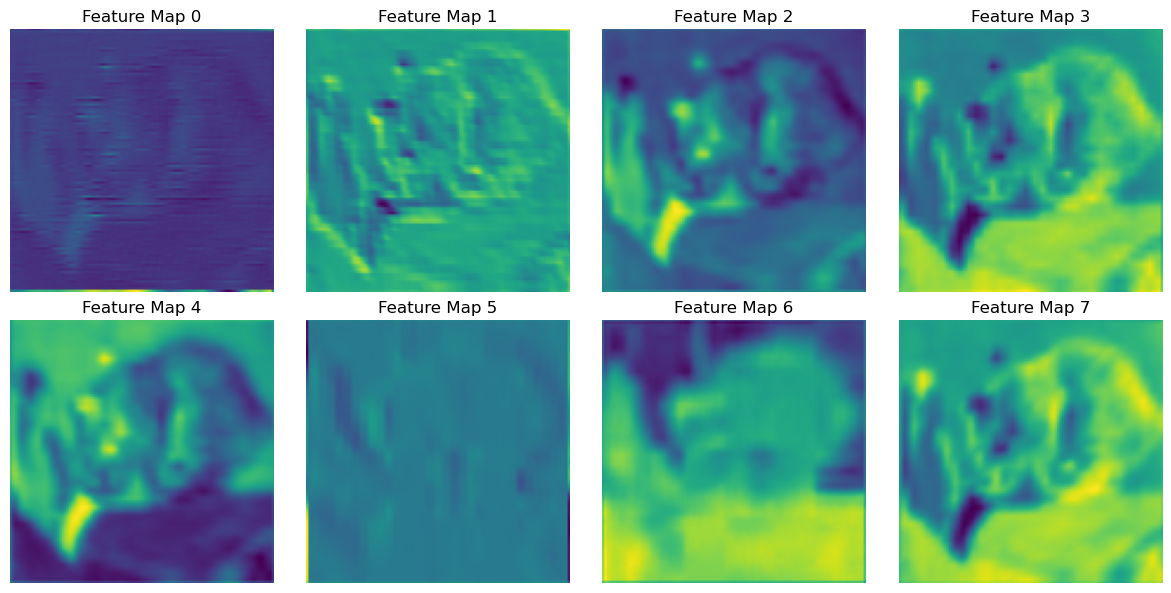

In [53]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# 1. Load sample image from CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
sample_img, label = dataset[0]  # Get the first image and its label
input_tensor = sample_img.unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]

# 2. Load pretrained ResNet18
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

model.eval()

# 3. Hook into the first convolution layer to extract feature maps
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach())

hook = model.conv1.register_forward_hook(hook_fn)

# 4. Forward pass
_ = model(input_tensor)

# 5. Visualize first 8 feature maps
activation = feature_maps[0].squeeze(0)  # Shape: [64, H, W]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(activation[i].cpu(), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Feature Map {i}')
plt.tight_layout()
plt.show()

# 6. Cleanup
hook.remove()